In [1]:
# Javier de la Cruz
# Ian Álvarez

In [2]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import ttk
import time
from copy import copy
import mido


from synt.function import *
from synt.const import *
from synt.synt import *
from synt.osc import *

from synt.envolv import *
from synt.effects import *
from synt.instrumento import *
from synt.mixer import *

import os

In [3]:
'''MOSTAR ONDAS COPIANDOLAS PARA QUE NO SE ALTERE EL FRAME'''
from copy import copy
def showOsc(osc, time, chunks=False):
    _osc = copy(osc)
    signal = np.zeros(0)
    _chunks = int(time*(SRATE+CHUNK)/CHUNK)
    if chunks:
        _chunks = time
    for i in range(_chunks):
        signal = np.concatenate((signal, _osc.next()))
    plt.plot(signal)

In [4]:
'''REPRODUCTOR'''
input = None

def callback(outdata, frames, time, status):
    global input
    # print('entro')
    if input is not None:
        bloque = input.next()
        # convertimos formato (CHUNK,) a (CHUNK,1) para que adecuarlo a sounddevice
        outdata[:] = bloque.reshape(-1, 1)
    else:
        # si no hay datos, reproducimos silencio
        outdata[:] = np.zeros((CHUNK, 1))


# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, channels=2, callback=callback, blocksize=CHUNK)
stream.start()

In [5]:
raise Exception("Para de ejecutar!!") #(comentar para ejecutar todo de una)


Exception: Para de ejecutar!!

## Instrumento por defecto

In [5]:
root = Tk()
os.system('xset r off')
env = EnvInstrumento(.1, .1, .7, .3)
synt = Synt(C(1), Sine(C(1)))
inst = Instrumento(root, synt, env)
input = inst
# inst.noteOn(-20)
# showOsc(inst, 0.5)
root.mainloop()
input = None

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
523.2511306011972
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
noteOn 48
261.6255653005986
noteOff 48
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
noteOn 48
261.6255653005986
noteOff 48
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
noteOff 48
off
noteOn 48
261.6255653005986
not

## Secuenciador Midi multi instrumernto

In [6]:
class MidiSequencerTk:
    # análogo a lo anterior
    def __init__(self,tk,instruments=None):
        if instruments == None:
            env = EnvInstrumento(.1, .1, .7, .3)
            synt = Synt(C(1), Sine(C(1)))
            self.instruments = [Instrumento(root, synt, env)]            
        else:
            self.instruments = instruments

        frame = LabelFrame(tk, text="Midi Sequencer", bg="#908060")
        frame.pack(side=TOP)

        frameFile = Frame(frame, highlightbackground="blue", highlightthickness=6)
        frameFile.pack(side=TOP)
        Label(frameFile,text='Archivo MIDI: ').pack(side=LEFT)
 
        self.file = Entry(frameFile) #.pack(side=RIGHT)
        self.file.insert(14,"pirates.mid")
        self.file.pack(side=LEFT)

        self.transport = 0
        
        
        self.text = Text(frame,height=6,width=23)
        self.text.pack(side=RIGHT)
        playBut = Button(frame,text="Play", command=self.play)
        playBut.pack(side=TOP)
        stopBut = Button(frame,text="Stop", command=self.stop)
        stopBut.pack(side=BOTTOM)

        self.tick = 1
        self.state = 'off'
        
    # obtención de la secuencia midi (noteOn/Off) con tiempos relativos al inicio
    def getSeq(self,midiEvents):
        seq = []
        accTime = 0
        for m in midiEvents:
            accTime += m.time
            if m.type=='note_on':
                if m.velocity==0: seq.append((accTime,'noteOff',m.note+self.transport,m.channel))
                else: seq.append((accTime,'noteOn',m.note+self.transport,m.channel))    
            elif m.type=='note_off':
                seq.append((accTime,'noteOff',m.note+self.transport,m.channel))
        return seq

  
    def play(self):
        events = mido.MidiFile(self.file.get())
        seq = self.getSeq(events)
        print(seq)

        self.state = 'on'
        self.playLoop(seq)

    def playLoop(self,seq,item=0,accTime=0):   
        if item>=len(seq) or self.state =='off':
            return

        # ahora tenemos que procesar todos los ítems cuyo tiempo supere el crono accTime    
        while item<len(seq) and accTime>=seq[item][0]:
            (_,msg,midiNote,_chan) = seq[item]  # (time,'noteOff',midNote,channel)
            self.text.insert('6.0',  f'{msg} {midiNote} {_chan}\n') 
            if msg=='noteOn':  
                self.instruments[_chan % len(self.instruments)].noteOn(midiNote)                   
            else: # msg noteOff    
                self.instruments[_chan % len(self.instruments)].noteOff(midiNote)                   
            item += 1 # y avanzmos ítem


        # avanzammos crono 
        accTime += self.tick/1000

        self.text.after(self.tick,lambda: self.playLoop(seq,item,accTime)) 

         
    def stop(self):
        self.instruments.stop()
        self.state = 'off'   


In [9]:
tk = Tk()
_lins = []

env0 = EnvInstrumento(0.02,0.01,0.4,1)
synt0 = Synt(C(1), Triangle(C(1)))
ins0 = Instrumento(tk, synt0, env0, "tri")

env1 = EnvInstrumento(0.05,0.01,0.4,0.5)
synt1 = Synt(C(1), Sawtooth(C(1)))
ins1 = Instrumento(tk, synt1, env1, "saw")

env2 = EnvInstrumento(0.05,0.01,0.4,0.5)
synt2 = HarmSynt(C(1), [C(1), C(4.3/12), C(9.5/12), C(4/12)], [Sine(C(1), phase=Square(C(45))), Sine(C(2)), Triangle(C(4)), Sine(C(4), phase=Sine(C(234), min=C(0), max=C(.5)))], amp=C(.7))
ins2 = Instrumento(tk, synt2, env2, "loco")

env3 = EnvInstrumento(0.05,0.01,0.4,0.5)
synt3 = HarmSynt(C(1), [C(1), C(.26 + 4.1/24), C(.5 + 8.35/48), C(1/8)], [Sine(C(1), phase=Square(C(45))), Sine(C(2)), Triangle(C(4)), Sine(C(4), phase=Sine(C(234), min=C(0), max=C(.5)))], amp=C(.65))
ins3 = Instrumento(tk, synt3, env3, "loco2")

# env3 = EnvInstrumento()

_lins = [ins2, ins3, ins0, ins1]

0.7
0.65


In [10]:
input = None
def callback(outdata, frames, time, status):    
    if status: print(status)    
    #print(inputs)
    s = np.sum([i.next() for i in inputs],axis=0)
    s = np.float32(s)
    outdata[:] = s.reshape(-1, 1)

# os.system('xset r off')


seq = MidiSequencerTk(tk,_lins)
#print(seq.seq)
inputs = _lins

stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)
stream.start()

tk.mainloop()

stream.close()
# os.system('xset r on')


invalid command name "135958584865280<lambda>"
    while executing
"135958584865280<lambda>"
    ("after" script)
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


output underflow
[(3.0, 'noteOn', 60, 0), (3.0, 'noteOn', 60, 1), (3.0, 'noteOn', 72, 1), (3.0, 'noteOn', 63, 1), (3.0, 'noteOn', 67, 1), (3.7500000000000004, 'noteOff', 60, 0), (3.7500000000000004, 'noteOn', 63, 0), (4.5, 'noteOff', 63, 0), (4.5, 'noteOn', 65, 0), (4.5, 'noteOff', 67, 1), (4.5, 'noteOff', 63, 1), (4.5, 'noteOff', 60, 1), (4.5, 'noteOn', 65, 1), (4.5, 'noteOn', 68, 1), (5.0625, 'noteOff', 65, 0), (5.0625, 'noteOn', 63, 0), (5.625, 'noteOff', 63, 0), (5.625, 'noteOn', 65, 0), (6.0, 'noteOff', 65, 0), (6.0, 'noteOn', 65, 0), (6.0, 'noteOff', 68, 1), (6.0, 'noteOff', 65, 1), (6.0, 'noteOff', 72, 1), (6.0, 'noteOn', 58, 1), (6.0, 'noteOn', 65, 1), (6.0, 'noteOn', 70, 1), (6.0, 'noteOn', 74, 1), (6.75, 'noteOff', 65, 0), (6.75, 'noteOn', 70, 0), (7.125, 'noteOff', 70, 0), (7.125, 'noteOn', 68, 0), (7.5, 'noteOff', 68, 0), (7.5, 'noteOn', 67, 0), (7.5, 'noteOff', 74, 1), (7.5, 'noteOff', 58, 1), (7.5, 'noteOff', 65, 1), (7.5, 'noteOn', 63, 1), (7.5, 'noteOn', 67, 1), (7.5, '

# Experimentos

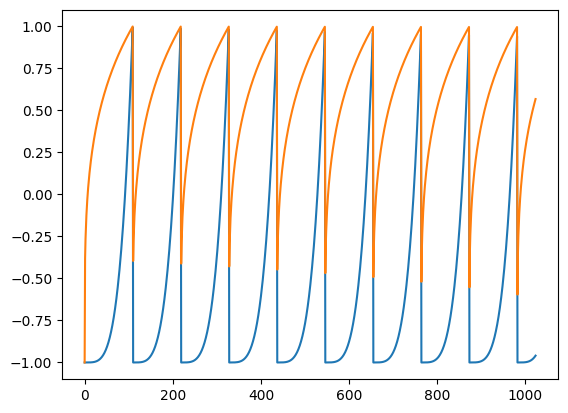

In [9]:

freq = C(440)
s1 = Rep(freq, XP(valor=freq, pow=C(4)) * C(2) - C(1))
s2 = Rep(freq, XP(valor=freq, pow=C(1/4)) * C(2) - C(1))
# s2 = Rep(C(440), XP(valor=C(440), pow=C(2)) * C(2) - C(1), phase=Sine(C(440)))
s3 = Sawtooth(freq, phase=C(np.pi/2))
showOsc(s1, 1, True)
showOsc(s2, 1, True)
# showOsc(s3, 1, True)
input = s1

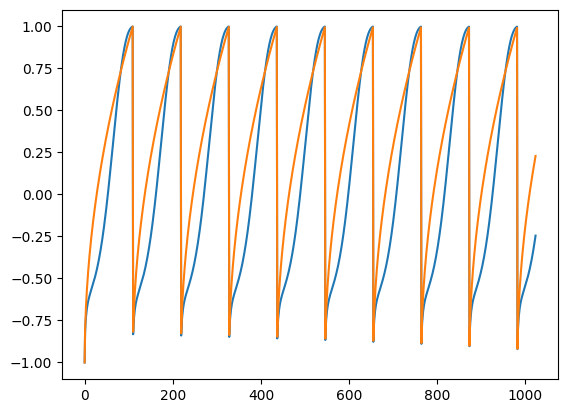

In [86]:
freq = C(440)
s1 = Rep(freq, XP(valor=freq, pow=Sine(freq / C(1.5), min=C(0))) * C(2) - C(1)) # * C(2) - C(1) es para que vaya de -1 a 1 
s2 = Rep(freq, XP(valor=freq, pow=C(1/2)) * C(2) - C(1))
s3 = Sawtooth(freq, phase=C(np.pi/2))
showOsc(s1, 1, True)
showOsc(s2, 1, True)
# showOsc(s3, 1, True)
input = s1